# This jupyter notebook test the VERT_FSFB3.py function with a sample $N^2$ profile in the California coastal region

In [1]:
import numpy as np

import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# First we calculate the Brunt-Vaisla frequency squared with a sample dataset.

In [3]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [5]:
state_ds = xr.open_dataset('./SWOT_state_2015-01-06.nc')
#state_ds.YC

In [6]:
LAT, LON = state_ds.YC.data, state_ds.XC.data

In [7]:
lat, lon = np.meshgrid(LAT, LON)

# Read Temperature, Salinity and Pressure data

In [8]:
temp = state_ds.THETA
salinity = state_ds.SALT
pres  = state_ds.PHIHYD

In [9]:
Z = state_ds.Z
#gsw.stability.Nsquared?

# Calculate Brunt-Vaisla frequency squared

In [10]:
SA, CT, = np.ma.masked_all(salinity.shape), np.ma.masked_all(temp.shape)
Nsquared = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
Pressure_mid = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
Z_mid = np.ma.masked_all([salinity.shape[0]-1, salinity.shape[1], salinity.shape[2]])
for y in range(SA.shape[1]):
    for x in range(SA.shape[2]):
        SA[:, y, x] = gsw.conversions.SA_from_SP(salinity.data[:, y, x], pres.data[:, y, x], LON[x], LAT[y])
        CT[:, y, x] = gsw.CT_from_pt(SA.data[:, y, x], temp.data[:, y, x])  
        Nsquared[:, y, x], Pressure_mid[:, y, x] = gsw.stability.Nsquared(SA[:, y, x], CT[:, y, x], pres[:, y, x])
        Z_mid[:, y, x] = gsw.z_from_p(Pressure_mid[:, y, x] , lat = LAT[y])

/Users/yugao/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/gsw/stability.py:85: RuntimeWarning: divide by zero encountered in true_divide
  N2 = ((g_local**2) / (specvol_mid * db_to_pa * dp))


In [11]:
xlon, ylat = np.meshgrid(LON, LAT)

In [12]:
zz, yy = np.meshgrid(Z[1:], LAT)

# Choose a vector at a random location

In [13]:
laty, lonx = 100, 120

In [14]:
N2_vector = Nsquared[:, laty, lonx]
Pmid_vector = Pressure_mid[:, laty, lonx]
#Pmid_vector, N2_vector

## Interpolate the N2 vector onto a uniform pressure grid

In [15]:
Pmid_uniform = np.arange(Pmid_vector[0], Pmid_vector[-1], step = 6)
N2_uniform = np.interp(Pmid_uniform, Pmid_vector, N2_vector)

In [16]:
Pmid_uniform = Pmid_uniform[:]
N2_uniform = N2_uniform[:]
#Pmid_uniform, N2_uniform

In [17]:
import VERT_FSFB3

In [18]:
c2, Psi, G, N2, Pmid = VERT_FSFB3.VERT_FSFB3(N2_uniform, Pmid_uniform)

In [19]:
g = 9.81 # gravity

## With a rigid lid assumpsion, SSH = Gm/g, where g is gravity, since hydrastatic pressure p = $rho * g *  SSH$

In [20]:
SSH = G/g

In [21]:
Z_mid_uniform  = gsw.z_from_p(np.append(0,Pmid), lat = laty)

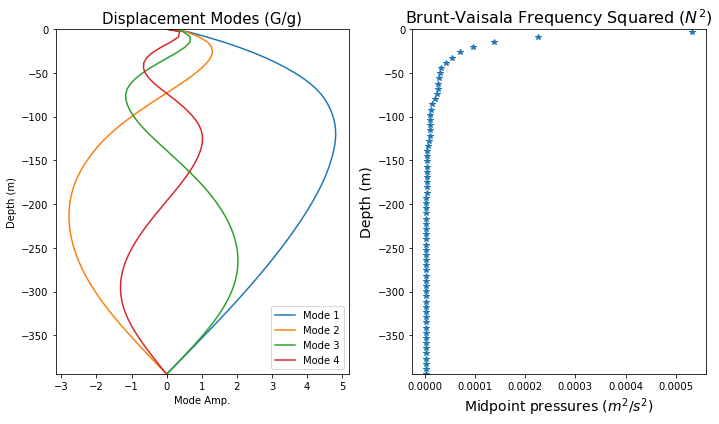

In [22]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(SSH[:,0], Z_mid_uniform, label = 'Mode 1')
plt.plot(SSH[:,1], Z_mid_uniform, label = 'Mode 2')
plt.plot(SSH[:,2], Z_mid_uniform, label = 'Mode 3')
plt.plot(SSH[:,3], Z_mid_uniform, label = 'Mode 4')
#plt.plot(SSH[:,4], Z_mid_uniform, label = 'Mode 5')
plt.xlabel('Mode Amp.')
plt.ylabel('Depth (m)')
#plt.xlim([-.2, .2])
plt.ylim([Z_mid_uniform.min(), 0])
plt.legend()
plt.title('Displacement Modes (G/g)', fontsize = 15)

plt.subplot(122)
plt.title('Brunt-Vaisala Frequency Squared ($N^2$)', fontsize = 16)
plt.plot(N2, Z_mid_uniform[1:], '*')
#plt.plot(Pmid_vector[:], N2_vector,  linewidth  = 2.0)
plt.xlabel('Midpoint pressures (${m^2}/{s^2}$)', fontsize = 14)
plt.ylabel('Depth (m)', fontsize = 14)
#plt.xlim([10, 350])
plt.ylim([Z_mid_uniform.min(), 0])

plt.tight_layout()
plt.savefig('vertical_modes_N2_sample_CCS_lon_' + str(lonx) + '_lat_' + str(laty) +'.png')

In [23]:
MODE = G.shape[-1]

In [24]:
Zgrid, mode = np.meshgrid(Z_mid_uniform, range(MODE) )

/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_2263/53837551.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_2263/53837551.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_2263/53837551.py:25: MatplotlibDeprecati

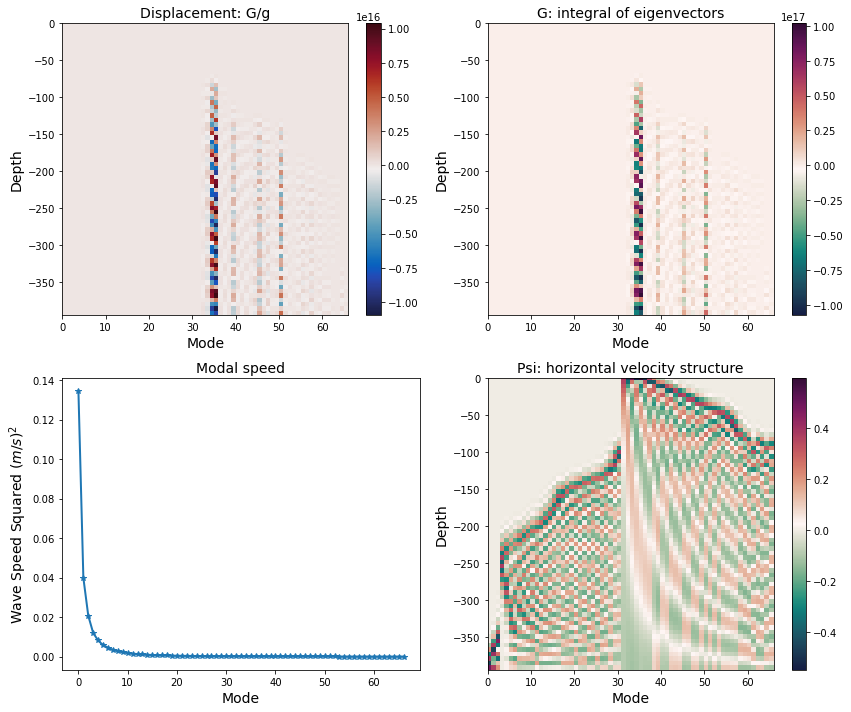

In [25]:
plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title('Displacement: G/g', fontsize = 14)
plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(222)
plt.title('G: integral of eigenvectors', fontsize = 14)
plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(223)
plt.title('Modal speed' , fontsize = 14)
plt.plot(c2[:], "-*", linewidth = 2)
plt.ylabel('Wave Speed Squared $(m/s)^2$', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
#plt.colorbar()

plt.subplot(224)
plt.title('Psi: horizontal velocity structure' , fontsize = 14)
plt.pcolor(mode, Zgrid, Psi[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.tight_layout()
plt.savefig('vertical_modes_FSFB2_N2_sample_lon_' + str(lonx) + '_lat_' + str(laty) +'.png', dpi = 100)

### Beta plane paramters

In [26]:
# wavespeed = # -c2[0]
Phi0 = 30 # central latitude (φ0)
Omega = 7.2921159e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
# Gradient of Coriolis parameter f = f0 + beta * (y-y0) 
# The constant β (the Rossby parameter) is given its value at a central latitude (φ0) on the spherical earth, 
# (2Ω cosφ0)/a, where Ω is the angular speed of the earth and a its mean radius. 
Beta

3.53106090197239e-12

## Choose a wave with 200-km wavelength that moves westward (negative wave speed). 

In [56]:
wavelength = 2e5 # 200km
wavespeed = c2[0] # m/s 
np.sqrt(wavespeed)

0.3665943486332322

## The dispersion relation relates frequency to wavenumber for each mode:

In [57]:
k_n = 2 * np.pi / wavelength # wavenumber
k_n

3.141592653589793e-05

## Rossby deformation radius Rm = c/f0

In [58]:
Rm = wavespeed / f0
Rm

-932.6466350245602

In [59]:
freq_n = (Beta * k_n) / (k_n ** 2 + Rm ** -2) #+ 
freq_n

9.64087960936197e-11

## SSH First Baroclinic mode

### Amplitude

In [60]:
Amn, Bmn = 0.5, 1.5 #Amn = amp[0, 1]*Psi[0, 1], 

In [61]:
X_loc = np.arange(0, 1e6, 1e3)
T_time = np.arange(0, 100e5, 1e5)

In [62]:
SSH = np.ma.masked_all([len(X_loc), len(T_time)])
for xx in range(len(X_loc)):
    for tt in range(len(T_time)):
        SSH[xx, tt] = Amn * np.cos(k_n * X_loc[xx] + freq_n * T_time[tt]) + Amn * np.sin(k_n * X_loc[xx] + freq_n * T_time[tt])

In [63]:
XX, TT = np.meshgrid(X_loc/1000, T_time/86400)
#XX.shape, TT.shape, Amn, Bmn

/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_2263/2480837288.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX[:, :], TT[:, :], SSH[ :].T, cmap = cmo.cm.balance)


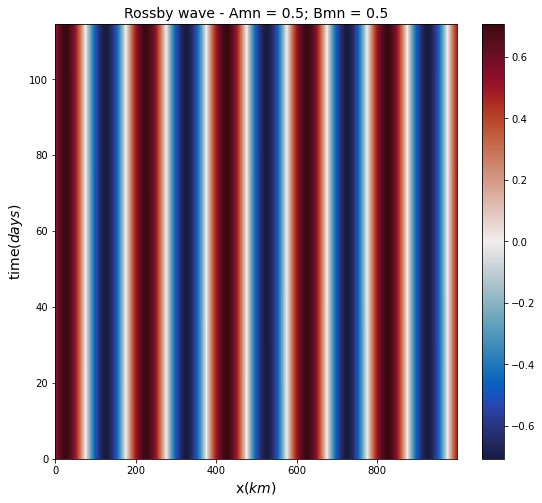

In [64]:
plt.figure(figsize=(9, 8))
plt.title('Rossby wave - Amn = 0.5; Bmn = 0.5', fontsize = 14)
plt.pcolormesh(XX[:, :], TT[:, :], SSH[ :].T, cmap = cmo.cm.balance)
plt.colorbar()
plt.ylabel('time($days$)', fontsize = 14)
plt.xlabel('x($km$)', fontsize = 14)
plt.savefig('rossby_wave_1stmode_AA.png', dpi = 100)

In [65]:
ds_output = xr.Dataset(data_vars={'SSH' : (('time', 'x'), SSH.T),
                                  'time' : (('time'), T_time),
                                  'x' : (('x'), X_loc)},
                      attrs = dict(description=('Rossby wave SSH(x, t) with first baroclinic mode, Amn = 0.5, Bmn = 0.5.')))
ds_output.to_netcdf('./Rossby_wave_1st_mode_AA.nc')

### Amplitude

In [37]:
Amn, Bmn = 0.5, 1.5 #Amn = amp[0, 1]*Psi[0, 1], 

In [38]:
SSH_AB = np.ma.masked_all([len(X_loc), len(T_time)])
for xx in range(len(X_loc)):
    for tt in range(len(T_time)):
        SSH_AB[xx, tt] = Amn*np.cos(k_n * X_loc[xx] + freq_n*T_time[tt]) + Bmn*np.sin(k_n*X_loc[xx] + freq_n*T_time[tt])

/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_2263/2803443315.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX[:, :], TT[:, :], SSH_AB[ :].T, cmap = cmo.cm.balance)


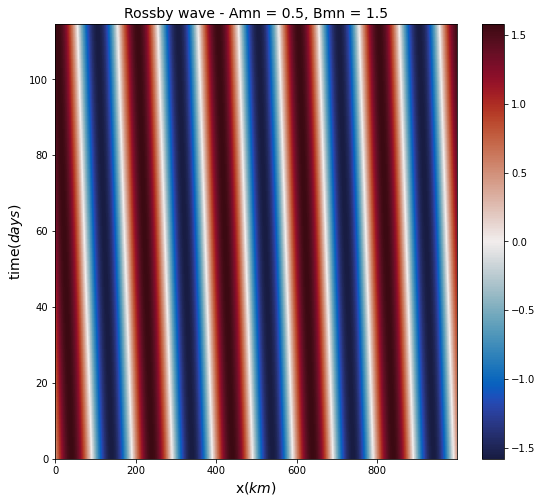

In [39]:
plt.figure(figsize=(9, 8))
plt.title('Rossby wave - Amn = 0.5, Bmn = 1.5', fontsize = 14)
plt.pcolormesh(XX[:, :], TT[:, :], SSH_AB[ :].T, cmap = cmo.cm.balance)
plt.colorbar()
plt.ylabel('time($days$)', fontsize = 14)
plt.xlabel('x($km$)', fontsize = 14)
plt.savefig('rossby_wave_1stmode_AB.png', dpi = 100)

In [40]:
ds_output = xr.Dataset(data_vars={'SSH' : (('time', 'x'), SSH_AB.T),
                                  'time' : (('time'), T_time),
                                  'x' : (('x'), X_loc)},
                      attrs = dict(description=('Rossby wave SSH(x, t) with first baroclinic mode, Amn = 0.5, Bmn = 1.5.')))
ds_output.to_netcdf('./Rossby_wave_1st_mode_AB.nc')

## SSH First Two Baroclinic mode